In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

plt.style.use('seaborn-v0_8')
plt.rcParams['legend.framealpha'] = 1  ## disable any default legend frame transparency from the style

dirpath_data = Path('/home/lain/root/100_work/110_projects/111_mars/code-repos/redplanet/scrap/250408_modlab_nmr/exp_modern_phys_388/nmr/nmr_data')

Fit: A_fit = 78.652, B_fit = 1.451e-03

* T_2 = 1.451e-03 s


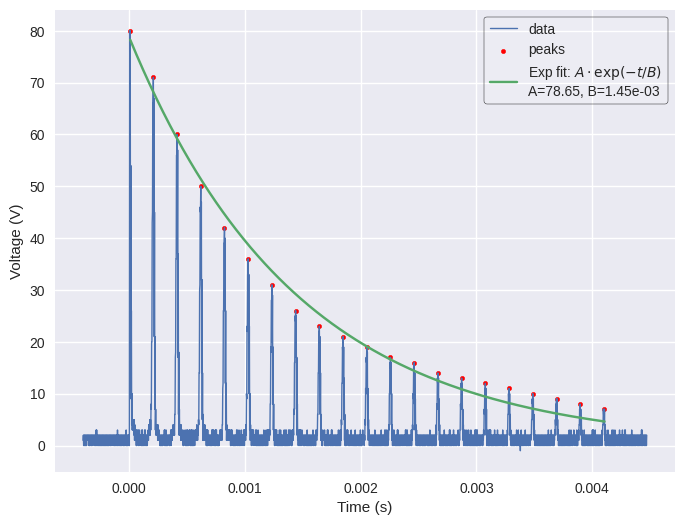

In [2]:
'''load data'''

fname = 'carr-purcell-sequence-2.csv'

fpath = dirpath_data / fname
df = pd.read_csv(
    fpath,
    usecols = [3,4,9,10],
    header = None,
    names = ['t1', 'v1', 't2', 'v2'],
    ## note: t1 and v1 look fucked up / meaningless, just ignore those p sure?
)



'''crop & scale'''

df['t2'] *= 0.02499999937
df['v2'] *= 5.00000007

df = df[
    (df['t2'] > -0.0004)
    # (df['t2'] < 0.1)
]



'''convert to 1D numpy arrays for convenience'''
dat_t = df['t2'].to_numpy()
dat_v = df['v2'].to_numpy()



'''find peaks'''
idx_peaks = find_peaks(
    dat_v,
    distance = 50,
    height = 5,
)[0]
dat_t_peaks = dat_t[idx_peaks]
dat_v_peaks = dat_v[idx_peaks]






'''fit'''
def exp_decay(t, A, B):
    return A * np.exp(-t/B)

popt, pcov = curve_fit(
    exp_decay,
    dat_t_peaks,
    dat_v_peaks,
    p0 = (50, 0.001),
)
A_fit, B_fit = popt
print(f'Fit: {A_fit = :.3f}, {B_fit = :.3e}')

print()
print(f'* T_2 = {B_fit:.3e} s')


dat_t_fit = np.linspace(
    dat_t_peaks.min(),
    dat_t_peaks.max(),
    1000,
)
dat_v_fit = exp_decay(dat_t_fit, A_fit, B_fit)















'''plot'''

fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(
#     dat[:,0],
#     dat[:,1],
#     label = 't1',
#     alpha = 0.5,
# )

ax.plot(
    dat_t,
    dat_v,
    label = 'data',
    # alpha = 0.5,
    linewidth = 1,
)

ax.scatter(
    dat_t_peaks,
    dat_v_peaks,
    label = 'peaks',
    color = 'r',
    s = 10,
)



ax.plot(
    dat_t_fit,
    dat_v_fit,
    # 'k-',
    label = (
        r'Exp fit: $A \cdot \exp (-t/B)$'
        f'\nA={A_fit:.2f}, B={B_fit:.2e}',
    ),
)


ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')


# ax.set_xlim(-0.01, 0.16)
# ax.set_xbound(-0.02, dat_t.max())


legend = ax.legend(
    # loc='lower left',
    frameon=True,
)
frame = legend.get_frame()
frame.set_alpha(None)  ## disable any rcParam alpha override
frame.set_facecolor((1, 1, 1, 0.1))  ## set frame coloring to white with some transparency
frame.set_edgecolor('black')